In [1]:
import numpy as np
from FlowControl import add_to_class
import matplotlib.pyplot as plt
from pandas import DataFrame,Series

In [2]:
from sklearn.datasets import load_iris

In [3]:
data_set = load_iris()

data_dict = {
    "features" : DataFrame({data_set["feature_names"][i] : data_set["data"][:,i] for i in range(len(data_set["feature_names"]))}),
    "fetaure_names" : data_set["feature_names"],
    "targets" : Series({"y" : data_set["target"]}),
    "target_names" : data_set["target_names"]
}

In [4]:
from sklearn.model_selection import train_test_split

names = [data_dict["fetaure_names"][0],data_dict["fetaure_names"][1]]
X_data = data_dict["features"][names].to_numpy()
y_data = data_dict["targets"]["y"] == 0

X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,shuffle=True,train_size=0.7)

<h1>Gaussian discriminative analysis (GDA)</h1>

<h2>0. Multivariate Gaussian distribution</h2>

$$
\mathcal{N}(\vec{\mu},\Sigma) = \frac{1}{(2\pi)^{d/2}}|\Sigma|^{-1/2}\exp(-\frac{1}{2}(\vec{x}-\vec{\mu})^{T}\Sigma^{-1}(\vec{x}-\vec{\mu}))
$$
where $\Sigma$ is hermitian matrix with eigenvecotrs $\vec{a}_{i}$ and eigenvalues $\sigma_{i}^{2}$ which correspond to standard deviation of normal distribution along direction given by eigenvector $\vec{a}_{i}$.

In [5]:
colormap_theme = "cividis"

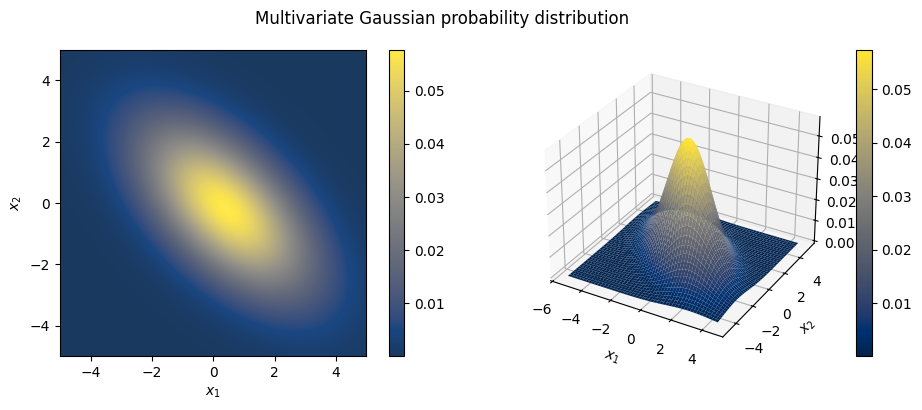

In [6]:
X_ = np.arange(-5,5,0.01)
x,y = np.meshgrid(X_,X_)

mu_x =  0.4
mu_y = -0.2

x -= mu_x
y -= mu_y

v = np.stack((x,y),axis = 2)
b1 = np.array([1,-1]) / np.sqrt(2)
b2 = np.array([1, 1]) / np.sqrt(2)

sig1 = 2.3
sig2 = 1.2

Sig_inv = (1 / sig1**2) * b1.reshape(-1,1) * b1 + (1 / sig2**2) * b2.reshape(-1,1) * b2
right = np.sum(Sig_inv[np.newaxis,np.newaxis,:,:] * v[:,:,np.newaxis,:],axis = 3)
ans = np.sum(v * right , axis = 2) 
prob = 1 / np.sqrt((2*np.pi)**2 * np.linalg.det(np.linalg.inv(Sig_inv))) * np.exp(-ans/2)

fig = plt.figure(figsize = (10,4))
fig.suptitle("Multivariate Gaussian probability distribution")

ax = fig.add_subplot(1,2,1)
im = ax.imshow(prob,origin='lower',extent = [X_.min(),X_.max(),X_.min(),X_.max()],alpha=0.9,cmap = colormap_theme)
fig.colorbar(im,ax = ax)
ax.set_xlabel(r"$x_{1}$")
ax.set_ylabel(r"$x_{2}$")

ax2 = fig.add_subplot(1,2,2,projection = "3d")
im2 = ax2.plot_surface(x,y,prob,cmap = colormap_theme,alpha = 1 )
ax2.set_xlabel(r"$x_{1}$")
ax2.set_ylabel(r"$x_{2}$")
fig.colorbar(im2,ax = ax2)
plt.tight_layout()
plt.show()


<h2>1. Theoretical introduction</h2>

GDA is a classification algorithm which is working on the basis of 2 key assumptions:
1. There are $2$ main classes of objects, each of them are normally distributed in feature space with the same standard deviation matrix: $\mathcal{N}(\mu_{k},\Sigma)$ 
2. Probability of classifying $y$ as $1$ is given by distribution $\phi$. Therefore:
$$
p(y) = \phi^{y}(1-\phi)^{1-y}
$$

The first assumption can be re-written as:
$$
p(\vec{x}^{(i)}|\hat{y}^{(i)} = k; \vec{\mu}_{0},\vec{\mu}_{1},\Sigma,\phi) = \frac{1}{(2\pi)^{d/2}}|\Sigma|^{-1/2}\exp(-\frac{1}{2}(\vec{x}^{(i)}-\vec{\mu}_{k})^{T}\Sigma^{-1}(\vec{x}^{(i)}-\vec{\mu}_{k}))
$$

Cost function for our problem:
$$
\mathcal{L}(\vec{\mu}_{0},\vec{\mu}_{1},\Sigma,\phi) = -\sum_{i=1}^{n}\log{p(\vec{x}^{(i)},\hat{y}^{(i)} ; \vec{\mu}_{0},\vec{\mu}_{1},\Sigma,\phi)} = 
-\sum_{i=1}^{n}\log{p(\vec{x}^{(i)}|\hat{y}^{(i)} ; \vec{\mu}_{0},\vec{\mu}_{1},\Sigma,\phi)} p(\hat{y}^{(i)},\phi) = 
$$
$$
= n\Big( \frac{d}{2}\log(2\pi) + \frac{1}{2}\log(|\Sigma|) \Big) + \frac{1}{2}\sum_{i=1}^{n}\delta_{\hat{y}^{(i)}1}(\vec{x}^{(i)} - \vec{\mu}_{1})^{T}\Sigma^{-1}(\vec{x}^{(i)} - \vec{\mu}_{1}) + \frac{1}{2}\sum_{i=1}^{n}\delta_{\hat{y}^{(i)}0}(\vec{x}^{(i)} - \vec{\mu}_{0})^{T}\Sigma^{-1}(\vec{x}^{(i)} - \vec{\mu}_{0}) + 
\sum_{i=1}^{n} \big[\hat{y}^{(i)}\log{\phi}  + (1-\hat{y}^{(i)})\log(1-\phi)\big] 
$$

Parameters of the minimized cost function are defined by derivatives:
$$
\frac{\partial \mathcal{L}}{\partial \phi} = \sum_{i=1}^{n}\frac{\hat{y}^{(i)} - \phi}{\phi(1-\phi)} \hspace{1cm} \Rightarrow \hspace{1cm} \phi = \frac{1}{n}\sum_{i=1}^{n}\delta_{\hat{y}^{(i)}1}  
$$
$$
\frac{\partial \mathcal{L}}{\partial (\vec{\mu}_{k})_{j}} = \sum_{i=1}^{n}\delta_{\hat{y}^{(i)}k}([\Sigma^{-1}\vec{x}^{(i)}]_{j} - [\Sigma^{-1}\vec{\mu}_{k}]_{j}) \hspace{1cm} \Rightarrow \hspace{1cm} \vec{\mu}_{k} = \sum_{i=1}^{n}\delta_{\hat{y}^{(i)}k}\vec{x}^{(i)} / \sum_{i=1}^{n}\delta_{\hat{y}^{(i)}k}
$$
$$
\Sigma = \frac{1}{n}\sum_{i=1}^{n} (\vec{x}^{(i)} - \vec{\mu}_{\hat{y}^{(i)}}) (\vec{x}^{(i)} - \vec{\mu}_{\hat{y}^{(i)}})^{T}
$$

After finding these parameters, we can find total probability distribution using Bayes theorem:
$$
p(y = 1|\vec{x}) = \frac{p(\vec{x}|y = 1)p(y = 1)}{p(\vec{x})}
$$
$$
p(y = 0|\vec{x}) = \frac{p(\vec{x}|y = 0)p(y = 0)}{p(\vec{x})}
$$
$$
p(\vec{x}) = p(\vec{x} | y = 1)p(y=1) +  p(\vec{x} | y = 0)p(y=0)
$$

<h2>2. Impementation</h2>

In [7]:
class GDA:
    def __init__(self):
        pass

    def fit(self,X,y):
        classes = np.unique(y)
        n = X.shape[0]
        y_0 = (y == classes[0])
        y_1 = (y == classes[1])
        self.phi = sum(np.where(y_1 == True,1,0)) / n
        self.mu_0 = np.where(y_0 == True,1,0) @ X / sum(np.where(y_0 == True,1,0))
        self.mu_1 = np.where(y_1 == True,1,0) @ X / sum(np.where(y_1 == True,1,0))
        self.Sigma = sum((X[i,:] - (self.mu_0 if y_0[i] else self.mu_1)).reshape(-1,1) * (X[i,:] - (self.mu_0 if y_0[i] else self.mu_1)).T for i in range(n)) / n
        return self.phi,self.mu_0,self.mu_1,self.Sigma
    
    def predict_plane(self,X_to_pred):
        assert len(X_to_pred.shape) == 3 and X_to_pred.shape[2] == 2, "invalid shape"
        inv_Sigma = np.linalg.inv(self.Sigma)
        def inner(mu):
            X_shift = X_to_pred - mu
            distr = np.sum(inv_Sigma[np.newaxis,np.newaxis,:,:] * X_shift[:,:,np.newaxis,:],axis = 3)
            distr = np.sum(X_shift * distr,axis = 2)
            return distr
        
        Sigma_det = np.linalg.det(self.Sigma)
        prob_x_0 =  1/np.sqrt((2*np.pi)**2*Sigma_det) * np.exp(-inner(self.mu_0)/2)
        prob_x_1 =  1/np.sqrt((2*np.pi)**2*Sigma_det) * np.exp(-inner(self.mu_1)/2)

        prob_x = (1-self.phi) * prob_x_0 + self.phi * prob_x_1
        prob_y_0 = prob_x_0 * (1-self.phi) / prob_x
        prob_y_1 = prob_x_1 * self.phi / prob_x

        return prob_y_0,prob_y_1,prob_x_0,prob_x_1
    
    def predict_arr(self,X_to_pred):
        inv_Sigma = np.linalg.inv(self.Sigma)
        def inner(mu):
            X_shift = X_to_pred - mu
            distr = inv_Sigma @ X_shift.T
            distr = np.sum(X_shift * distr.T,axis = 1)
            return distr
        
        Sigma_det = np.linalg.det(self.Sigma)
        prob_x_0 =  1/np.sqrt((2*np.pi)**2*Sigma_det) * np.exp(-inner(self.mu_0)/2)
        prob_x_1 =  1/np.sqrt((2*np.pi)**2*Sigma_det) * np.exp(-inner(self.mu_1)/2)

        prob_x = (1-self.phi) * prob_x_0 + self.phi * prob_x_1
        prob_y_0 = prob_x_0 * (1-self.phi) / prob_x
        prob_y_1 = prob_x_1 * self.phi / prob_x

        return prob_y_0,prob_y_1,prob_x_0,prob_x_1

In [8]:
print(X_train.shape)
print(y_train.shape)

(105, 2)
(105,)


In [9]:
model_gda = GDA()
phi,mu0,mu1,sig = model_gda.fit(X_train,y_train) 

print(f"phi = {phi}")
print(f"mu_0 = {mu0}")
print(f"mu_1 = {mu1}")
print(f"sigma = \n{sig}")


phi = 0.3238095238095238
mu_0 = [6.28450704 2.88591549]
mu_1 = [5.04411765 3.48823529]
sigma = 
[[0.30606458 0.10516337]
 [0.10516337 0.1129639 ]]


In [10]:
x0min = X_data[:,0].min() - 0.5
x0max = X_data[:,0].max() + 0.5
x1min = X_data[:,1].min() - 0.5
x1max = X_data[:,1].max() + 0.5

x0_ = np.arange(x0min,x0max,0.01)
x1_ = np.arange(x1min,x1max,0.01)
x0,x1 = np.meshgrid(x0_,x1_)
X_ = np.stack((x0,x1),axis = 2)

prob0,prob1,prob_x_0,prob_x_1 = model_gda.predict_plane(X_)
pred_vals = np.argmax(np.stack((prob0,prob1),axis = 2),axis = 2)

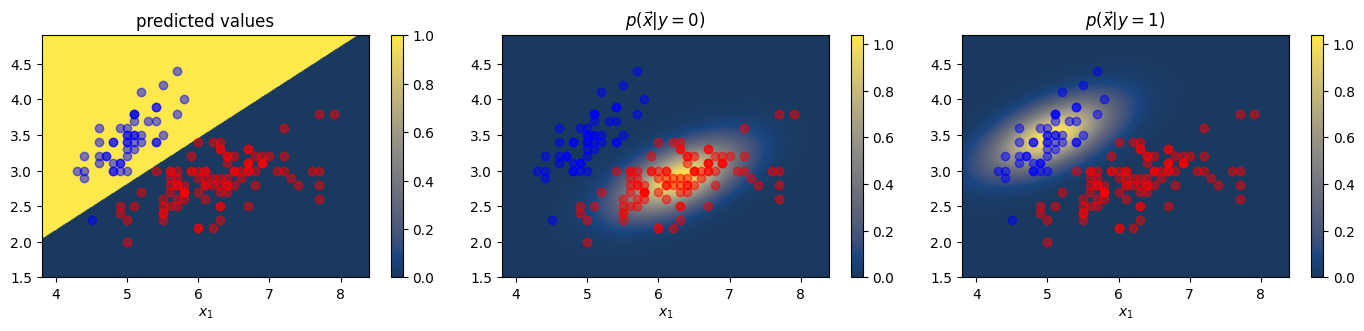

In [11]:
inds = (y_data == 0)
inds_prime = (y_data != 0)

fig = plt.figure(figsize = (14,3))

def vis_classes(ax,data,title):
    im = ax.imshow(data,origin='lower',extent=[x0min,x0max,x1min,x1max],alpha = 0.9,cmap = colormap_theme)
    ax.scatter(X_data[:,0][inds],X_data[:,1][inds],color = "red",alpha = 0.5)
    ax.scatter(X_data[:,0][inds_prime],X_data[:,1][inds_prime],color = "blue",alpha = 0.5)
    ax.set_xlabel(r"$x_{0}$")
    ax.set_xlabel(r"$x_{1}$")
    ax.set_title(title)
    fig.colorbar(im,ax = ax)

ax = fig.add_subplot(1,3,1)
vis_classes(ax,pred_vals,"predicted values")
ax1 = fig.add_subplot(1,3,2)
vis_classes(ax1,prob_x_0,r"$p(\vec{x}|y = 0)$")
ax2 = fig.add_subplot(1,3,3)
vis_classes(ax2,prob_x_1,r"$p(\vec{x}|y = 1)$")

plt.tight_layout()
plt.show()


In [12]:
X_data_tot = data_dict["features"].to_numpy()
y_data_tot = data_dict["targets"]["y"] == 1

X_train_tot,X_test_tot,y_train_tot,y_test_tot = train_test_split(X_data_tot,y_data_tot,train_size=0.7)

In [13]:
model_tot_gda = GDA()
phi,mu0,mu1,sig = model_tot_gda.fit(X_train_tot,y_train_tot) 

print(f"phi = {phi}")
print(f"mu_0 = {mu0}")
print(f"mu_1 = {mu1}")
print(f"sigma = \n{sig}")

phi = 0.3333333333333333
mu_0 = [5.83142857 3.19857143 3.58428571 1.16285714]
mu_1 = [6.03428571 2.82       4.32571429 1.37428571]
sigma = 
[[ 0.69990204 -0.04867483  1.29070204  0.51011973]
 [-0.04867483  0.16177007 -0.28742449 -0.11748299]
 [ 1.29070204 -0.28742449  3.03523401  1.25906939]
 [ 0.51011973 -0.11748299  1.25906939  0.56352653]]


In [14]:
prob0_tot,prob1_tot,prob_x_0_tot,prob_x_1_tot = model_tot_gda.predict_arr(X_test_tot)
pred_vals_tot = np.argmax(np.vstack((prob0_tot,prob1_tot)),axis = 0)


In [15]:
def accuracy(y_pred,y_test):
    return 1 - np.abs(y_pred - y_test).sum() / len(y_pred)

In [16]:
print(accuracy(pred_vals_tot,y_test_tot))

0.8
